![](img/330-banner.png)

# Lecture 7: Linear Models


UBC 2023-24

Instructor: Varada Kolhatkar and Andrew Roth

## Imports, Announcements, and LO

### Imports

In [1]:
import os
import sys

sys.path.append("code/.")

import IPython
import ipywidgets as widgets
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
from IPython.display import HTML, display
from ipywidgets import interact, interactive
from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from utils import *

%matplotlib inline
pd.set_option("display.max_colwidth", 200)

### Announcements

- Homework 3 is due on Oct 2nd.

## Learning outcomes

From this lecture, students are expected to be able to: 

- Explain the general intuition behind linear models;
- Explain how `predict` works for linear regression;
- Use `scikit-learn`'s `Ridge` model; 
- Demonstrate how the `alpha` hyperparameter of `Ridge` is related to the fundamental tradeoff; 
- Explain the difference between linear regression and logistic regression;   
- Use `scikit-learn`'s `LogisticRegression` model and `predict_proba` to get probability scores
- Explain the advantages of getting probability scores instead of hard predictions during classification; 
- Broadly describe linear SVMs 
- Explain how can you interpret model predictions using coefficients learned by a linear model; 
- Explain the advantages and limitations of linear classifiers. 

<br><br>

## Linear models [[video](https://youtu.be/HXd1U2q4VFA)]

**Linear models** is a fundamental and widely used class of models. They are called **linear** because they make a prediction using a **linear function** of the input features.  

We will talk about three linear models: 
- Linear regression 
- Logistic regression
- Linear SVM (brief mention)

### Linear regression 

- A very popular statistical model and has a long history.  
- Imagine a hypothetical regression problem of predicting weight of a snake given its length. 

In [2]:
np.random.seed(7)
n = 100
X_1 = np.linspace(0, 2, n) + np.random.randn(n) * 0.01
X = pd.DataFrame(X_1[:, None], columns=["length"])

y = abs(np.random.randn(n, 1)) * 3 + X_1[:, None] * 5 + 0.2
y = pd.DataFrame(y, columns=["weight"])
snakes_df = pd.concat([X, y], axis=1)
train_df, test_df = train_test_split(snakes_df, test_size=0.2, random_state=77)

X_train = train_df[["length"]].values
y_train = train_df["weight"].values
X_test = test_df[["length"]].values
y_test = test_df["weight"].values
train_df.head()

,length,weight
73,1.489130,10.507995
53,1.073233,7.658047
80,1.622709,9.748797
49,0.984653,9.731572
23,0.484937,3.016555


Let's visualize the hypothetical snake data. 

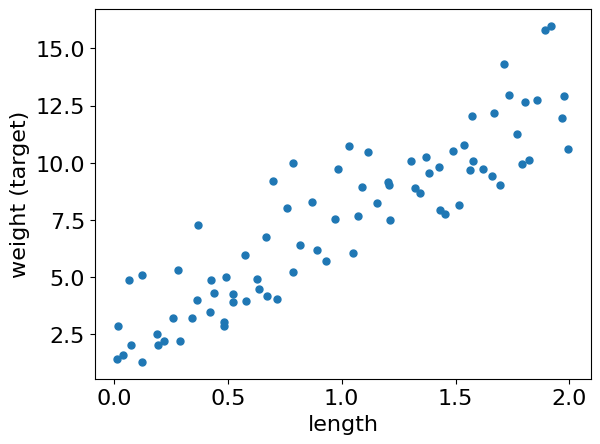

In [3]:
plt.plot(X_train, y_train, ".", markersize=10)
plt.xlabel("length")
plt.ylabel("weight (target)");

Let's plot a linear regression model on this dataset. 

In [4]:
grid = np.linspace(min(X_train)[0], max(X_train)[0], 1000)
grid = grid.reshape(-1, 1)

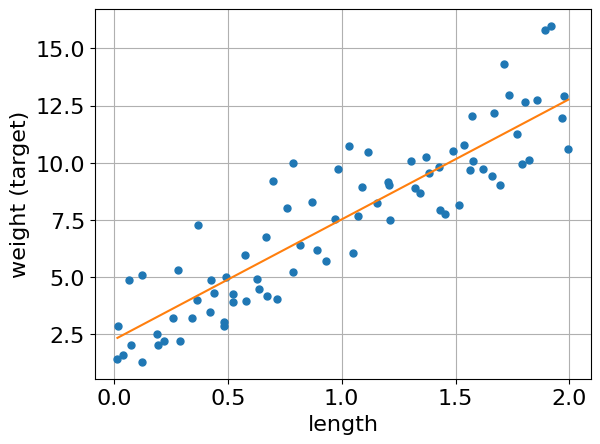

In [5]:
from sklearn.linear_model import Ridge

r = Ridge()
r.fit(X_train, y_train)
plt.plot(X_train, y_train, ".", markersize=10)
plt.plot(grid, r.predict(grid))
plt.grid(True)
plt.xlabel("length")
plt.ylabel("weight (target)");

**The orange line is the learned linear model.**

### Prediction of linear regression

- Given a snake length, we can use the model above to predict the target (i.e., the weight of the snake). 
- The prediction will be the corresponding weight on the orange line. 

In [6]:
snake_length = 0.75
r.predict([[snake_length]])

array([6.20683258])

#### What are we exactly learning? 

- The model above is a line, which can be represented with a slope (i.e., coefficient or weight) and an intercept. 
- For the above model, we can access the slope (i.e., coefficient or weight) and the intercept using `coef_` and `intercept_`, respectively. 

In [7]:
r.coef_  # r is our linear regression object

array([5.26370005])

In [8]:
r.intercept_  # r is our linear regression object

2.259057547817185

### How are we making predictions? 
- Given a feature value $x_1$ and learned coefficient $w_1$ and intercept $b$, we can get the prediction $\hat{y}$ with the following formula:
$$\hat{y} = w_1x_1 + b$$

In [9]:
prediction = snake_length * r.coef_ + r.intercept_
prediction

array([6.20683258])

In [10]:
r.predict([[snake_length]])

array([6.20683258])

Great! Now we exactly know how the model is making the prediction. 

### Generalizing to more features
For more features, the model is a higher dimensional hyperplane and the general prediction formula looks as follows: 

$\hat{y} =$ <font color="red">$w_1$</font> <font color="blue">$x_1$ </font> $+ \dots +$ <font color="red">$w_d$</font> <font color="blue">$x_d$</font> + <font  color="green"> $b$</font>

where, 
- <font  color="blue"> ($x_1, \dots, x_d$) are input features </font>
- <font  color="red"> ($w_1, \dots, w_d$) are coefficients or weights </font> (learned from the data)
- <font  color="green"> $b$ is the bias which can be used to offset your hyperplane </font> (learned from the data)

### Example 

- Suppose these are the coefficients learned by a linear regression model on a hypothetical housing price prediction dataset. 

| Feature | Learned coefficient |
|--------------------|---------------------:|
| Bedrooms | 0.20 |
| Bathrooms| 0.11 |
| Square Footage | 0.002 |
| Age | -0.02 |

- Now given a new example, the target will be predicted as follows: 
| Bedrooms | Bathrooms | Square Footage | Age |
|--------------------|---------------------|----------------|-----| 
| 3                  | 2                   | 1875           | 66  |

$$\hat{y} = w_1x_1 + w_2x_2 + w_3x_3 + w_4x_4 + b$$

$$\text{predicted price}=  0.20 \times 3 + 0.11 \times 2 + 0.002 \times 1875 + (-0.02) \times 66 + b$$

When we call `fit`, a coefficient or weight is learned for each feature which tells us the role of that feature in prediction. These coefficients are learned from the training data.  

```{important}
In linear models for regression, the model is a line for a single feature, a plane for two features, and a hyperplane for higher dimensions. We are not yet ready to discuss how does linear regression learn these coefficients and intercept.
```

### `Ridge`

- `scikit-learn` has a model called `LinearRegression` for linear regression. 
- But if we use this "vanilla" version of linear regression, it may result in large coefficients and unexpected results. 
- So instead of using `LinearRegression`, we will always use another linear model called `Ridge`, which is a linear regression model with a complexity hyperparameter `alpha`.

In [11]:
from sklearn.linear_model import LinearRegression  # DO NOT USE IT IN THIS COURSE
from sklearn.linear_model import Ridge  # USE THIS INSTEAD

#### Data

Let's use `sklearn`'s built in regression dataset, the Boston Housing dataset. The task associated with this dataset is to predict the median value of homes in several Boston neighborhoods in the 1970s, using information such as crime rate in the neighbourhood, average number of rooms, proximity to the Charles River, highway accessibility, and so on.

In [12]:
from sklearn.datasets import fetch_california_housing


california = fetch_california_housing()
X_train, X_test, y_train, y_test = train_test_split(
    california.data, california.target, test_size=0.2
)
pd.DataFrame(X_train, columns=california.feature_names)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,2.0000,52.0,5.303030,1.082251,725.0,3.138528,38.03,-121.88
1,2.0000,52.0,5.506410,1.134615,1026.0,3.288462,34.00,-118.30
2,4.0474,30.0,5.419355,1.006452,858.0,2.767742,37.31,-121.94
3,3.2794,7.0,5.546473,1.044166,5146.0,3.392221,34.46,-117.20
4,2.5551,35.0,4.018487,1.016807,1886.0,3.169748,37.35,-121.86
...,...,...,...,...,...,...,...,...
16507,3.0185,17.0,4.205479,0.863014,434.0,1.981735,34.61,-120.16
16508,12.6320,5.0,7.462963,0.888889,208.0,3.851852,34.44,-119.31
16509,3.9808,20.0,5.678689,1.006557,999.0,3.275410,38.28,-121.20
16510,5.8195,25.0,6.585513,0.961771,1645.0,3.309859,33.71,-117.97


In [13]:
print(california.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

#### `Ridge` on the California housing dataset

In [14]:
pipe = make_pipeline(StandardScaler(), Ridge())
scores = cross_validate(pipe, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.009113,0.000614,0.599492,0.608050
1,0.003294,0.000414,0.613507,0.604619
2,0.002804,0.000372,0.598100,0.608468
3,0.002764,0.000375,0.612621,0.604797
4,0.002914,0.000498,0.601790,0.606902


#### Hyperparameter `alpha` of `Ridge`

- Ridge has hyperparameters just like the rest of the models we learned.
- The alpha hyperparameter is what makes `Ridge` different from vanilla `LinearRegression`. 
- Similar to the other hyperparameters that we saw, `alpha` controls the fundamental tradeoff. 

```{note}
If we set alpha=0 that is the same as using LinearRegression.
```

Let's examine the effect of `alpha` on the fundamental tradeoff. 

In [15]:
scores_dict = {
    "alpha": 10.0 ** np.arange(-3, 6, 1),
    "mean_train_scores": list(),
    "mean_cv_scores": list(),
}
for alpha in scores_dict["alpha"]:
    pipe_ridge = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    scores = cross_validate(pipe_ridge, X_train, y_train, return_train_score=True)
    scores_dict["mean_train_scores"].append(scores["train_score"].mean())
    scores_dict["mean_cv_scores"].append(scores["test_score"].mean())

results_df = pd.DataFrame(scores_dict)

In [16]:
results_df

,alpha,mean_train_scores,mean_cv_scores
0,0.001,0.606567,0.605101
1,0.010,0.606567,0.605101
2,0.100,0.606567,0.605101
3,1.000,0.606567,0.605102
4,10.000,0.606557,0.605100
5,100.000,0.605696,0.604320
6,1000.000,0.579432,0.578523
7,10000.000,0.431137,0.430868
8,100000.000,0.116167,0.115956


Here we do not really see overfitting but in general, 
- larger `alpha` $\rightarrow$ likely to underfit
- smaller `alpha` $\rightarrow$ likely to overfit

#### Coefficients and intercept

The model learns 
- coefficients associated with each feature
- the intercept or bias

Let's examine the coefficients learned by the model. 

In [17]:
pipe_ridge = make_pipeline(StandardScaler(), Ridge(alpha=1.0))
pipe_ridge.fit(X_train, y_train)
coeffs = pipe_ridge.named_steps["ridge"].coef_

In [18]:
pd.DataFrame(data=coeffs, index=california.feature_names, columns=["Coefficients"])

,Coefficients
MedInc,0.827039
HouseAge,0.117058
AveRooms,-0.265273
AveBedrms,0.307521
Population,-0.003194
AveOccup,-0.039498
Latitude,-0.895963
Longitude,-0.866110


- The model also learns an intercept (bias). 
- For each prediction, we are adding this amount irrespective of the feature values.  

In [19]:
pipe_ridge.named_steps["ridge"].intercept_

2.0667579112160865

Can we use this information to interpret model predictions? 

## ❓❓ Questions for you

### (iClicker) Exercise 7.1 

**iClicker cloud join link: https://join.iclicker.com/3DP5H**

**Select all of the following statements which are TRUE.**

- (A) Increasing the hyperparameter `alpha` of `Ridge` is likely to decrease model complexity.
- (B) `Ridge` can be used with datasets that have multiple features.
- (C) With Ridge, we learn one coefficient per training example.
- (D) If you train a linear regression model on a 2-dimensional problem (2 features), the model will learn 3 parameters: one for each feature and one for the bias term. 

<br><br><br><br>

## Interpretation of coefficients 

- One of the main advantages of linear models is that they are relatively easy to interpret. 
- We have one coefficient per feature which kind of describes the role of the feature in the prediction according to the model. 

There are two pieces of information in the coefficients based on

- Sign
- Magnitude

### Sign of the coefficients

In the example below, for instance: 
- MedInc (median income) has a **positive coefficient**
    - the prediction will be proportional to the feature value; as MedInc gets **bigger**, the median house value gets **bigger** 
- AveRooms (Average number of rooms) has a **negative coefficient**
    - the prediction will be inversely proportional to the feature value; as AveRooms gets **bigger**, the median house value gets **smaller**

In [20]:
pd.DataFrame(data=coeffs, index=california.feature_names, columns=["Coefficients"])

,Coefficients
MedInc,0.827039
HouseAge,0.117058
AveRooms,-0.265273
AveBedrms,0.307521
Population,-0.003194
AveOccup,-0.039498
Latitude,-0.895963
Longitude,-0.866110


#### Magnitude of the coefficients

- Bigger magnitude $\rightarrow$ bigger impact on the prediction 
- In the example below, both MedInc and AveBedrms have a positive impact on the prediction but MedInc would have a bigger positive impact because it's feature value is going to be multiplied by a number with a bigger magnitude. 

In [21]:
data = {
    "coefficient": pipe_ridge.named_steps["ridge"].coef_.tolist(),
    "magnitude": np.absolute(pipe_ridge.named_steps["ridge"].coef_.tolist()),
}
coef_df = pd.DataFrame(data, index=california.feature_names).sort_values(
    "magnitude", ascending=False
)
coef_df

,coefficient,magnitude
Latitude,-0.895963,0.895963
Longitude,-0.866110,0.866110
MedInc,0.827039,0.827039
AveBedrms,0.307521,0.307521
AveRooms,-0.265273,0.265273
HouseAge,0.117058,0.117058
AveOccup,-0.039498,0.039498
Population,-0.003194,0.003194


### Importance of scaling 
- When you are interpreting the model coefficients, scaling is crucial. 
- If you do not scale the data, features with smaller magnitude are going to get coefficients with bigger magnitude whereas features with bigger scale are going to get coefficients with smaller magnitude.
- That said, when you scale the data, feature values become hard to interpret for humans!

```{Important}
Take these coefficients with a grain of salt. They might not always match your intuitions. Also, they do not tell us about how the world works. They only tell us about how the prediction of your model works. 
```

<br><br>

## ❓❓ Questions for you

- Discuss the importance of scaling when interpreting linear regression coefficients. 
- What might be the meaning of complex vs simpler model in case of linear regression? 

<br><br><br><br>

## Logistic regression [[video](https://youtu.be/56L5z_t22qE)]

### Logistic regression intuition 

- A linear model for **classification**. 
- Similar to linear regression, it learns weights associated with each feature and the bias. 
- It applies a **threshold** on the raw output to decide whether the class is positive or negative. 
- In this lecture we will focus on the following aspects of logistic regression.  
    - `predict`, `predict_proba` 
    - how to use learned coefficients to interpret the model

### Motivating example 

- Consider the problem of predicting sentiment expressed in movie reviews. 

#### Training data for the motivating example


<blockquote> 
    <p>Review 1: This movie was <b>excellent</b>! The performances were oscar-worthy!  👍 </p> 
    <p>Review 2: What a <b>boring</b> movie! I almost fell asleep twice while watching it. 👎 </p> 
    <p>Review 3: I enjoyed the movie. <b>Excellent</b>! 👍 </p>             
</blockquote>  

- Targets: positive 👍 and negative 👎
- Features: words (e.g., *excellent*, *flawless*, *boring*)


#### Learned coefficients associated with all features

- Suppose our vocabulary contains only the following 7 words. 
- A linear classifier learns **weights** or **coefficients** associated with the features (words in this example).  
- Let's ignore bias for a bit. 

![](img/words_coeff.png)

<!-- <center>
<img src='./img/words_coeff.png' width="250" height="300" />
</center>  
 -->

#### Predicting with learned weights 
- Use these learned coefficients to make predictions. For example, consider the following review $x_i$. 
<blockquote> 
It got a bit <b>boring</b> at times but the direction was <b>excellent</b> and the acting was <b>flawless</b>.
</blockquote>
- Feature vector for $x_i$: [1, 0, 1, 1, 0, 0, 0]

![](img/words_coeff.png)
<!-- <center>
<img src='./img/words_coeff.png' width="250" height="300" />
</center>  
 -->
- $score(x_i) = $ coefficient(*boring*) $\times 1$ + coefficient(*excellent*) $\times 1$ + coefficient(*flawless*) $\times 1$ = $-1.40 + 1.93 + 1.43 = 1.96$

- $1.96 > 0$ so predict the review as positive 👍. 

Weighted sum of the input features = 1.960 y_hat = pos


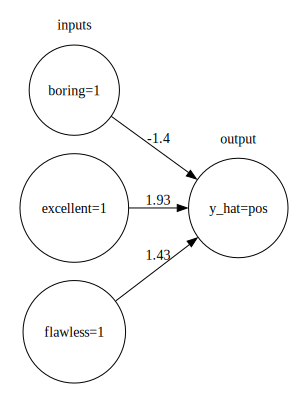

In [22]:
x = ["boring=1", "excellent=1", "flawless=1"]
w = [-1.40, 1.93, 1.43]
display(plot_logistic_regression(x, w))

- So the prediction is based on the weighted sum of the input features.
- Some feature are pulling the prediction towards positive sentiment and some are pulling it towards negative sentiment. 
- If the coefficient of _boring_ had a bigger magnitude or _excellent_ and _flawless_ had smaller magnitudes, we would have predicted "neg".   

In [23]:
def f(w_0):
    x = ["boring=1", "excellent=1", "flawless=1"]
    w = [-1.40, 1.93, 1.43]
    w[0] = w_0
    print(w)
    display(plot_logistic_regression(x, w))

In [24]:
interactive(
    f,
    w_0=widgets.FloatSlider(min=-6, max=2, step=0.5, value=-1.40),
)

interactive(children=(FloatSlider(value=-1.4, description='w_0', max=2.0, min=-6.0, step=0.5), Output()), _dom…

In our case, for values for the coefficient of _boring_ < -3.36, the prediction would be negative. 

A linear model learns these coefficients or weights from the training data! 

So a linear classifier is a linear function of the input `X`, followed by a threshold. 

\begin{equation}
\begin{split}
z =& w_1x_1 + \dots + w_dx_d + b\\
=& w^Tx + b
\end{split}
\end{equation}

$$\hat{y} = \begin{cases}
         1, & \text{if } z \geq r\\
         -1, & \text{if } z < r
\end{cases}$$

#### Components of a linear classifier

1. input features ($x_1, \dots, x_d$)
2. coefficients (weights) ($w_1, \dots, w_d$)
3. bias ($b$ or $w_0$) (can be used to offset your hyperplane)
4. threshold ($r$)

In our example before, we assumed $r=0$ and $b=0$.

### Logistic regression on the cities data

In [25]:
cities_df = pd.read_csv("data/canada_usa_cities.csv")
train_df, test_df = train_test_split(cities_df, test_size=0.2, random_state=123)
X_train, y_train = train_df.drop(columns=["country"]).values, train_df["country"].values
X_test, y_test = test_df.drop(columns=["country"]).values, test_df["country"].values

cols = train_df.drop(columns=["country"]).columns
train_df.head()

,longitude,latitude,country
160,-76.4813,44.2307,Canada
127,-81.2496,42.9837,Canada
169,-66.0580,45.2788,Canada
188,-73.2533,45.3057,Canada
187,-67.9245,47.1652,Canada


Let's first try `DummyClassifier` on the cities data. 

In [26]:
dummy = DummyClassifier()
scores = cross_validate(dummy, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.000252,0.000918,0.588235,0.601504
1,0.000147,0.000233,0.588235,0.601504
2,0.000139,0.000223,0.606061,0.597015
3,0.000131,0.000209,0.606061,0.597015
4,0.000117,0.000204,0.606061,0.597015


Now let's try `LogisticRegression`

In [27]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
scores = cross_validate(lr, X_train, y_train, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.010345,0.000499,0.852941,0.827068
1,0.004327,0.000433,0.823529,0.827068
2,0.003551,0.000326,0.696970,0.858209
3,0.002300,0.000284,0.787879,0.843284
4,0.002277,0.000346,0.939394,0.805970


Logistic regression seems to be doing better than dummy classifier. But note that there is a lot of variation in the scores. 

### Accessing learned parameters

- Recall that logistic regression learns the weights $w$ and bias or intercept $b$.

- How to access these weights? 
    - Similar to `Ridge`, we can access the weights and intercept using `coef_` and `intercept_` attribute of the `LogisticRegression` object, respectively. 

In [28]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Model weights: %s" % (lr.coef_))  # these are the learned weights
print("Model intercept: %s" % (lr.intercept_))  # this is the bias term
data = {"features": cols, "coefficients": lr.coef_[0]}
pd.DataFrame(data)

Model weights: [[-0.04108149 -0.33683126]]
Model intercept: [10.8869838]


,features,coefficients
0,longitude,-0.041081
1,latitude,-0.336831


- Both negative weights 
- The weight of latitude is larger in magnitude. 
- This makes sense because Canada as a country lies above the USA and so we expect latitude values to contribute more to a prediction than longitude. 

### Prediction with learned parameters

Let's predict target of a test example. 

In [29]:
example = X_test[0, :]
example

array([-64.8001,  46.098 ])

#### Raw scores

- Calculate the raw score as: ```y_hat = np.dot(w, x) + b```

In [30]:
(
    np.dot(
        example,
        lr.coef_.reshape(
            2,
        ),
    )
    + lr.intercept_
)

array([-1.97817876])

- Apply the threshold to the raw score. 
- Since the prediction is < 0, predict "negative". 
- What is a "negative" class in our context? 
- With logistic regression, the model randomly assigns one of the classes as a positive class and the other as negative. 
    - Usually it would alphabetically order the target and pick the first one as negative and second one as the positive class. 

- The `classes_` attribute tells us which class is considered negative and which one is considered positive. - In this case, Canada is the negative class and USA is a positive class. 

In [31]:
lr.classes_

array(['Canada', 'USA'], dtype=object)

- So based on the negative score above (-1.978), we would predict Canada. 
- Let's check the prediction given by the model. 

In [32]:
lr.predict([example])

array(['Canada'], dtype=object)

Great! The predictions match! We exactly know how the model is making predictions. 

### Decision boundary of logistic regression

- The decision boundary of logistic regression is a **hyperplane** dividing the feature space in half. 

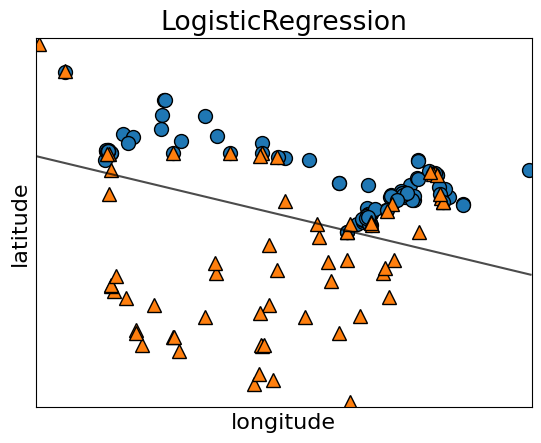

In [33]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
mglearn.plots.plot_2d_separator(lr, X_train, fill=False, eps=0.5, alpha=0.7)
plt.title(lr.__class__.__name__)
plt.xlabel("longitude")
plt.ylabel("latitude");

- For $d=2$, the decision boundary is a line (1-dimensional)
- For $d=3$, the decision boundary is a plane (2-dimensional)
- For $d\gt 3$, the decision boundary is a $d-1$-dimensional hyperplane

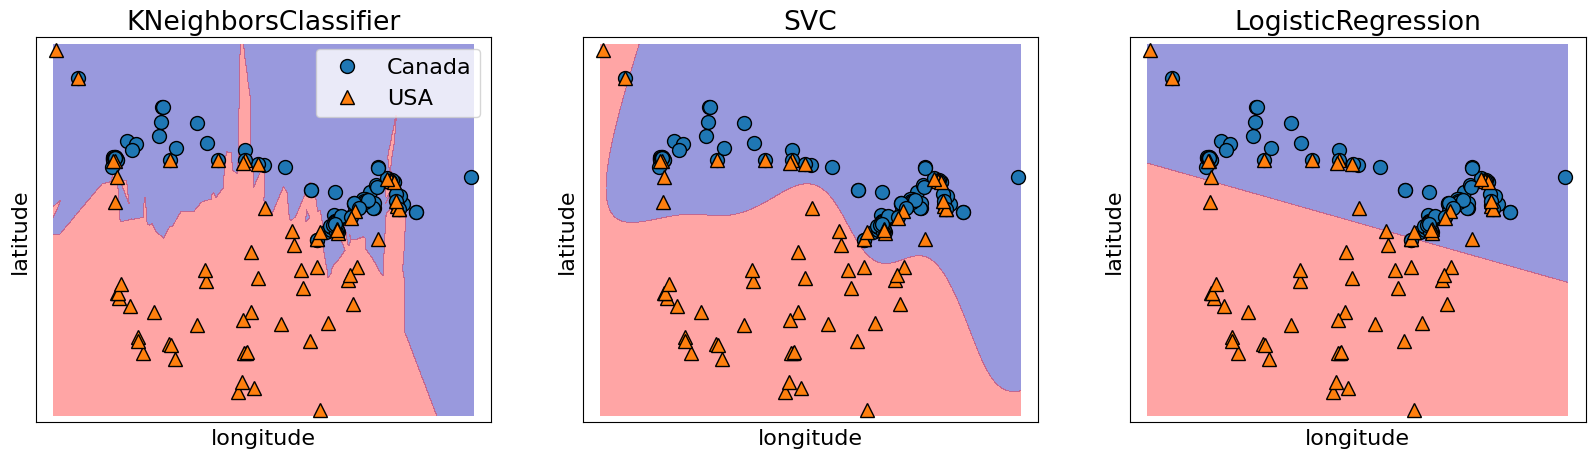

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for model, ax in zip(
    [KNeighborsClassifier(), SVC(gamma=0.01), LogisticRegression()], axes
):
    clf = model.fit(X_train, y_train)
    mglearn.plots.plot_2d_separator(
        clf, X_train, fill=True, eps=0.5, ax=ax, alpha=0.4
    )
    mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train, ax=ax)
    ax.set_title(clf.__class__.__name__)
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
axes[0].legend();

- Notice a linear decision boundary (a line in our case). 
- Compare it with  KNN or SVM RBF decision boundaries. 

### Main hyperparameter of logistic regression 

- `C` is the main hyperparameter which controls the fundamental trade-off.
- We won't really talk about the interpretation of this hyperparameter right now. 
- At a high level, the interpretation is similar to `C` of SVM RBF
    - smaller `C` $\rightarrow$ might lead to underfitting
    - bigger `C` $\rightarrow$ might lead to overfitting

In [35]:
scores_dict = {
    "C": 10.0 ** np.arange(-4, 6, 1),
    "mean_train_scores": list(),
    "mean_cv_scores": list(),
}
for C in scores_dict["C"]:
    lr = LogisticRegression(C=C)
    scores = cross_validate(lr, X_train, y_train, return_train_score=True)
    scores_dict["mean_train_scores"].append(scores["train_score"].mean())
    scores_dict["mean_cv_scores"].append(scores["test_score"].mean())

results_df = pd.DataFrame(scores_dict)
results_df

,C,mean_train_scores,mean_cv_scores
0,0.0001,0.664707,0.658645
1,0.0010,0.784424,0.790731
2,0.0100,0.827842,0.826203
3,0.1000,0.832320,0.820143
4,1.0000,0.832320,0.820143
5,10.0000,0.832320,0.820143
6,100.0000,0.832320,0.820143
7,1000.0000,0.832320,0.820143
8,10000.0000,0.832320,0.820143
9,100000.0000,0.832320,0.820143


<br><br><br><br>

## Predicting probability scores [[video](https://youtu.be/_OAK5KiGLg0)]

### `predict_proba`

- So far in the context of classification problems, we focused on getting "hard" predictions. 
- Very often it's useful to know "soft" predictions, i.e., how confident the model is with a given prediction.  
- For most of the `scikit-learn` classification models we can access this confidence score or probability score using a method called `predict_proba`.  

Let's look at probability scores of logistic regression model for our test example. 

In [36]:
example

array([-64.8001,  46.098 ])

In [37]:
lr = LogisticRegression(random_state=123)
lr.fit(X_train, y_train)
lr.predict([example])  # hard prediction

array(['Canada'], dtype=object)

In [38]:
lr.predict_proba([example])  # soft prediction

array([[0.87848688, 0.12151312]])

- The output of `predict_proba` is the probability of each class. 
- In binary classification, we get probabilities associated with both classes (even though this information is redundant). 
- The first entry is the estimated probability of the first class and the second entry is the estimated probability of the second class from `model.classes_`. 

In [39]:
lr.classes_

array(['Canada', 'USA'], dtype=object)

- Because it's a probability, the sum of the entries for both classes should always sum to 1. 
- Since the probabilities for the two classes sum to 1, exactly one of the classes will have a score >=0.5, which is going to be our predicted class.  

#### How does logistic regression calculate these probabilities? 

- The weighted sum $w_1x_1 + \dots + w_dx_d + b$ gives us "raw model output".
- For linear regression this would have been the prediction.
- For logistic regression, you check the **sign** of this value.
  - If positive (or 0), predict $+1$; if negative, predict $-1$.
  - These are "hard predictions".

- You can also have "soft predictions", aka **predicted probabilities**. 
  - To convert the raw model output into probabilities, instead of taking the sign, we apply the **sigmoid**.

#### The sigmoid function 
- The sigmoid function "squashes" the raw model output from any number to the range $[0,1]$ using the following formula, where $x$ is the raw model output. 
$$\frac{1}{1+e^{-x}}$$
- Then we can interpret the output as probabilities.

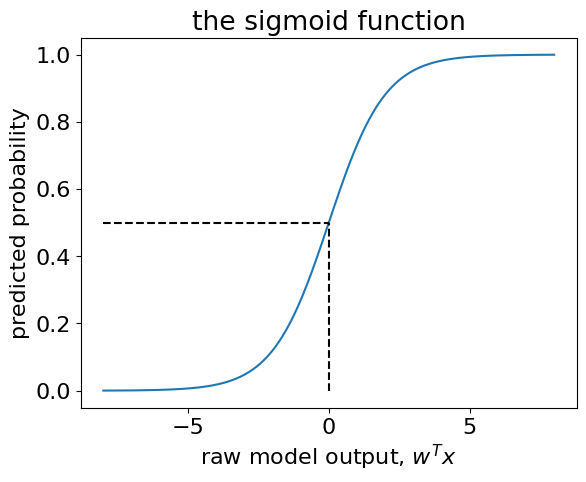

In [40]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))
raw_model_output = np.linspace(-8, 8, 1000)
plt.plot(raw_model_output, sigmoid(raw_model_output))
plt.plot([0, 0], [0, 0.5], "--k")
plt.plot([-8, 0], [0.5, 0.5], "--k")
plt.xlabel("raw model output, $w^Tx$")
plt.ylabel("predicted probability")
plt.title("the sigmoid function");

- Recall our hard predictions that check the sign of $w^Tx$, or, in other words, whether or not it is $\geq 0$.
  - The threshold $w^Tx=0$ corresponds to $p=0.5$. 
  - In other words, if our predicted probability is $\geq 0.5$ then our hard prediction is $+1$.

Let's get the probability score by calling sigmoid on the raw model output for our test example.

In [41]:
sigmoid(
    np.dot(
        example,
        lr.coef_.reshape(
            2,
        ),
    )
    + lr.intercept_
)

array([0.12151312])

This is the probability score of the positive class, which is USA. 

In [42]:
lr.predict_proba([example])

array([[0.87848688, 0.12151312]])

With `predict_proba`, we get the same probability score for USA!!

- Let's visualize probability scores for some examples. 

In [43]:
data_dict = {
    "y": y_train[:12],
    "y_hat": lr.predict(X_train[:12]).tolist(),
    "probabilities": lr.predict_proba(X_train[:12]).tolist(),
}

In [44]:
pd.DataFrame(data_dict)

,y,y_hat,probabilities
0,Canada,Canada,"[0.7046068097086478, 0.2953931902913523]"
1,Canada,Canada,"[0.5630169062040135, 0.43698309379598654]"
2,Canada,Canada,"[0.8389680973255862, 0.16103190267441386]"
3,Canada,Canada,"[0.7964150775404333, 0.20358492245956678]"
4,Canada,Canada,"[0.901080665234097, 0.09891933476590302]"
5,Canada,Canada,"[0.7753006388010788, 0.22469936119892117]"
6,USA,USA,"[0.030740704606528224, 0.9692592953934718]"
7,Canada,Canada,"[0.6880304799160926, 0.3119695200839075]"
8,Canada,Canada,"[0.7891358587234142, 0.21086414127658581]"
9,USA,USA,"[0.006546969753885579, 0.9934530302461144]"


The actual `y` and `y_hat` match in most of the cases but in some cases the model is more confident about the prediction than others. 

#### Least confident cases 

Let's examine some cases where the model is least confident about the prediction. 

In [45]:
least_confident_X = X_train[[127, 141]]
least_confident_X

array([[ -79.7599,   43.6858],
       [-123.078 ,   48.9854]])

In [46]:
least_confident_y = y_train[[127, 141]]
least_confident_y

array(['Canada', 'USA'], dtype=object)

In [47]:
probs = lr.predict_proba(least_confident_X)

data_dict = {
    "y": least_confident_y,
    "y_hat": lr.predict(least_confident_X).tolist(),
    "probability score (Canada)": probs[:, 0],
    "probability score (USA)": probs[:, 1],
}
pd.DataFrame(data_dict)

,y,y_hat,probability score (Canada),probability score (USA)
0,Canada,Canada,0.634392,0.365608
1,USA,Canada,0.635666,0.364334


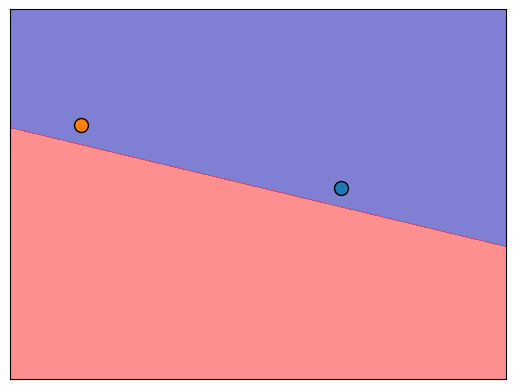

In [48]:
mglearn.discrete_scatter(
    least_confident_X[:, 0],
    least_confident_X[:, 1],
    least_confident_y,
    markers="o",
)
mglearn.plots.plot_2d_separator(lr, X_train, fill=True, eps=0.5, alpha=0.5)

The points are close to the decision boundary which makes sense. 

#### Most confident cases 

Let's examine some cases where the model is most confident about the prediction. 

In [49]:
most_confident_X = X_train[[37, 4]]
most_confident_X

array([[-110.9748,   32.2229],
       [ -67.9245,   47.1652]])

In [50]:
most_confident_y = y_train[[37, 165]]
most_confident_y

array(['USA', 'Canada'], dtype=object)

In [51]:
probs = lr.predict_proba(most_confident_X)

data_dict = {
    "y": most_confident_y,
    "y_hat": lr.predict(most_confident_X).tolist(),
    "probability score (Canada)": probs[:, 0],
    "probability score (USA)": probs[:, 1],
}
pd.DataFrame(data_dict)

,y,y_hat,probability score (Canada),probability score (USA)
0,USA,USA,0.010028,0.989972
1,Canada,Canada,0.901081,0.098919


In [52]:
most_confident_X

array([[-110.9748,   32.2229],
       [ -67.9245,   47.1652]])

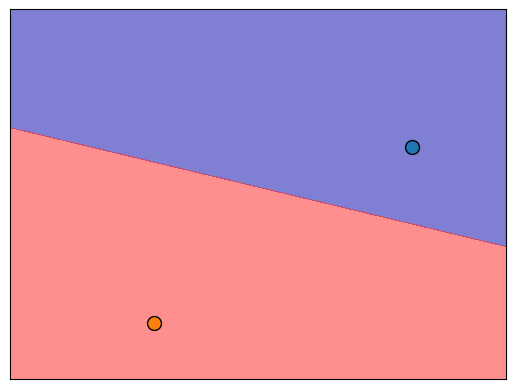

In [53]:
mglearn.discrete_scatter(
    most_confident_X[:, 0],
    most_confident_X[:, 1],
    most_confident_y,
    markers="o",
)
mglearn.plots.plot_2d_separator(lr, X_train, fill=True, eps=0.5, alpha=0.5)

The points are far away from the decision boundary which makes sense. 

#### Over confident cases

Let's examine some cases where the model is confident about the prediction but the prediction is wrong. 

In [54]:
over_confident_X = X_train[[25, 98]]
over_confident_X

array([[-129.9912,   55.9383],
       [-134.4197,   58.3019]])

In [55]:
over_confident_y = y_train[[25, 98]]
over_confident_y

array(['Canada', 'USA'], dtype=object)

In [56]:
probs = lr.predict_proba(over_confident_X)

data_dict = {
    "y": over_confident_y,
    "y_hat": lr.predict(over_confident_X).tolist(),
    "probability score (Canada)": probs[:, 0],
    "probability score (USA)": probs[:, 1],
}
pd.DataFrame(data_dict)

,y,y_hat,probability score (Canada),probability score (USA)
0,Canada,Canada,0.931792,0.068208
1,USA,Canada,0.961902,0.038098


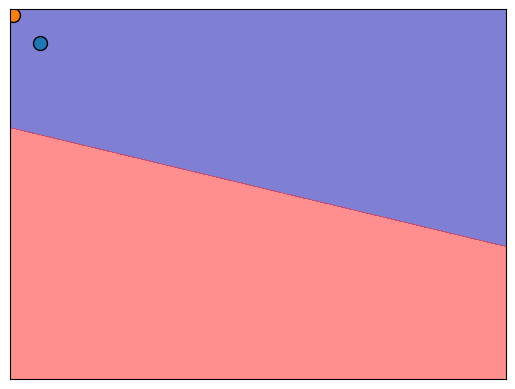

In [57]:
mglearn.discrete_scatter(
    over_confident_X[:, 0],
    over_confident_X[:, 1],
    over_confident_y,
    markers="o",
)
mglearn.plots.plot_2d_separator(lr, X_train, fill=True, eps=0.5, alpha=0.5)

- The cities are far away from the decision boundary. So the model is pretty confident about the prediction. 
- But the cities are likely to be from Alaska and our linear model is not able to capture that this part belong to the USA and not Canada.

Below we are using colour to represent prediction probabilities. If you are closer to the border, the model is less confident whereas the model is more confident about the mainland cities, which makes sense.  

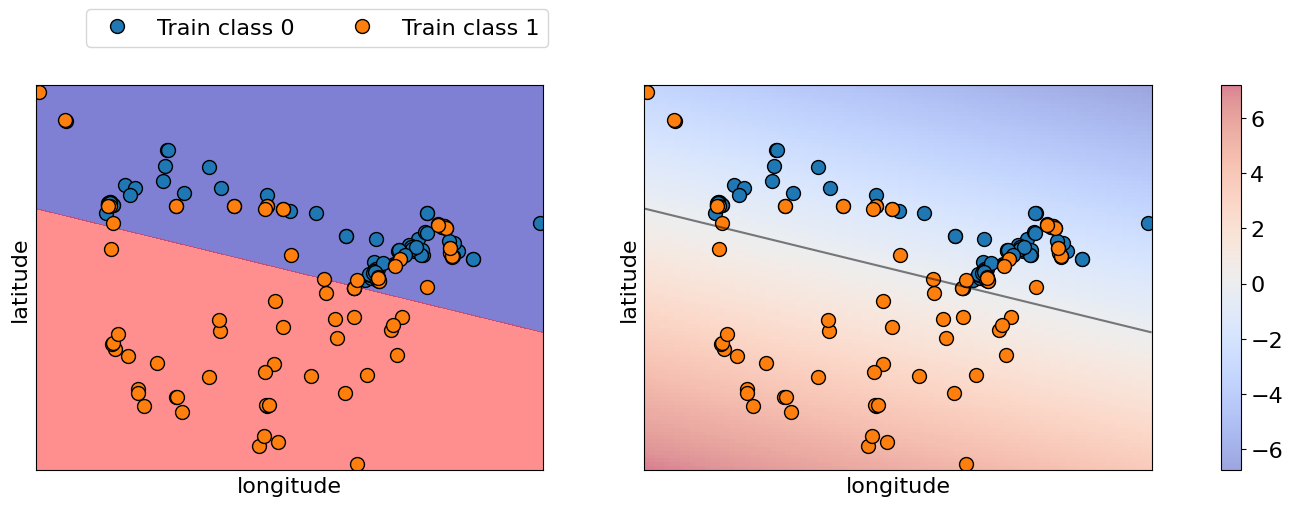

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
from matplotlib.colors import ListedColormap

for ax in axes:
    mglearn.discrete_scatter(
        X_train[:, 0], X_train[:, 1], y_train, markers="o", ax=ax
    )
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")

axes[0].legend(["Train class 0", "Train class 1"], ncol=2, loc=(0.1, 1.1))

mglearn.plots.plot_2d_separator(
    lr, X_train, fill=True, eps=0.5, ax=axes[0], alpha=0.5
)
mglearn.plots.plot_2d_separator(
    lr, X_train, fill=False, eps=0.5, ax=axes[1], alpha=0.5
)
scores_image = mglearn.tools.plot_2d_scores(
    lr, X_train, eps=0.5, ax=axes[1], alpha=0.5, cm=plt.cm.coolwarm
)
cbar = plt.colorbar(scores_image, ax=axes.tolist())

Sometimes a complex model that is overfitted, tends to make more confident predictions, even if they are wrong, whereas a simpler model tends to make predictions with more uncertainty. 

To summarize, 
- With hard predictions, we only know the class. 
- With probability scores we know how confident the model is with certain predictions, which can be useful in understanding the model better. 

## ❓❓ Questions for you

### (iClicker) Exercise 7.2 

**iClicker cloud join link: https://join.iclicker.com/3DP5H**

**Select all of the following statements which are TRUE.**

- (A) Increasing logistic regression's `C` hyperparameter increases model complexity.
- (B) The raw output score can be used to calculate the probability score for a given prediction. 
- (C) For linear classifier trained on $d$ features, the decision boundary is a $d-1$-dimensional hyperparlane.  
- (D) A linear model is likely to be uncertain about the data points close to the decision boundary. 

<br><br><br><br>

### Linear SVM 

- We have seen non-linear SVM with RBF kernel before. This is the default SVC model in `sklearn` because it tends to work better in many cases. 
- There is also a linear SVM. You can pass `kernel="linear"` to create a linear SVM. 

In [59]:
cities_df = pd.read_csv("data/canada_usa_cities.csv")
train_df, test_df = train_test_split(cities_df, test_size=0.2, random_state=123)
X_train, y_train = train_df.drop(columns=["country"]).values, train_df["country"].values
X_test, y_test = test_df.drop(columns=["country"]).values, test_df["country"].values

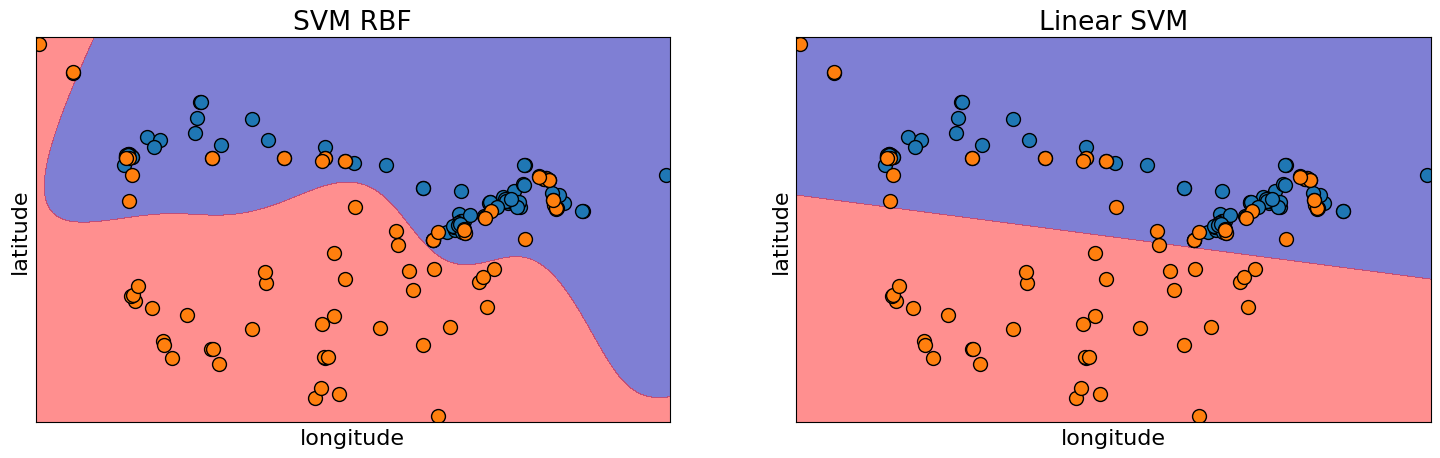

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))
from matplotlib.colors import ListedColormap

for (model, ax) in zip([SVC(gamma=0.01), SVC(kernel="linear")], axes):
    mglearn.discrete_scatter(
        X_train[:, 0], X_train[:, 1], y_train, markers="o", ax=ax
    )
    model.fit(X_train, y_train)
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
    mglearn.plots.plot_2d_separator(
        model, X_train, fill=True, eps=0.5, ax=ax, alpha=0.5
    )

axes[0].set_title("SVM RBF")
axes[1].set_title("Linear SVM");

- `predict` method of linear SVM and logistic regression works the same way. 
- We can get `coef_` associated with the features and `intercept_` using a Linear SVM model. 

In [61]:
linear_svc = SVC(kernel="linear")
linear_svc.fit(X_train, y_train)
print("Model weights: %s" % (linear_svc.coef_))
print("Model intercept: %s" % (linear_svc.intercept_))

Model weights: [[-0.0195598  -0.23640124]]
Model intercept: [8.22811601]


In [62]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Model weights: %s" % (lr.coef_))
print("Model intercept: %s" % (lr.intercept_))

Model weights: [[-0.04108149 -0.33683126]]
Model intercept: [10.8869838]


- Note that the coefficients and intercept are slightly different for logistic regression. 
- This is because the `fit` for linear SVM and logistic regression are different. 

<br><br><br><br>

<br><br><br><br>

## Summary of linear models 

- Linear regression is a linear model for regression whereas logistic regression is a linear model for classification. 
- Both these models learn one coefficient per feature, plus an intercept. 

### Main hyperparameters 
- The main hyperparameter is the "regularization" hyperparameter controlling the fundamental tradeoff. 
    - Logistic Regression: `C`
    - Linear SVM: `C` 
    - Ridge: `alpha`

### Interpretation of coefficients in linear models 
- the $j$th coefficient tells us how feature $j$ affects the prediction
- if $w_j > 0$ then increasing $x_{ij}$ moves us toward predicting $+1$
- if $w_j < 0$ then increasing $x_{ij}$ moves us toward prediction $-1$
- if $w_j == 0$ then the feature is not used in making a prediction

### Strengths of linear models 

- Fast to train and predict
- Scale to large datasets and work well with sparse data 
- Relatively easy to understand and interpret the predictions
- Perform well when there is a large number of features 

### Limitations of linear models 

- Is your data "linearly separable"? Can you draw a hyperplane between these datapoints that separates them with 0 error. 
    - If the training examples can be separated by a linear decision rule, they are **linearly separable**.



A few questions you might be thinking about
- How often the real-life data is linearly separable?
- Is the following XOR function linearly separable?  

| $$x_1$$ | $$x_2$$ | target|
|---------|---------|---------|
| 0 | 0  | 0|
| 0 | 1  | 1|
| 1 | 0  | 1|
| 1 | 1  | 0|    

- Are linear classifiers very limiting because of this?     